In [1]:
from dataset import load_cifar100
import tensorflow as tf
from resnet import resnet34, resnet18
import numpy as np

# define learning rate scheduler

In [2]:
class WarmUpAndCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, max_learning_rate, warmup_steps, total_steps):
        super(WarmUpAndCosineDecay, self).__init__()
        self.max_learning_rate = max_learning_rate
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps

        self.linear_warmup = 0
    def __call__(self, step):        
        self.linear_warmup = self.linear_warmup + self.max_learning_rate / self.warmup_steps        
        lr = tf.where(step < self.total_steps*0.6, 0.001, 0.0001)        
        lr = tf.where(step < self.warmup_steps, self.linear_warmup, lr)          
        return lr
                         

    def get_config(self):
        return {
            "max_learning_rate": self.max_learning_rate,
            "warmup_steps": self.warmup_steps,
            "total_steps": self.total_steps
        }
    

class ResNetPaperLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr = 0.1, lr_decay=10, steps=[32000, 48000]):
        super(ResNetPaperLR, self).__init__()
        self.initial_lr = initial_lr
        self.learning_rate_decay = lr_decay
        self.steps = steps
        self.current_lr = 0
    def __call__(self, step):        
        step12 = tf.where(step < self.steps[1], self.initial_lr/self.learning_rate_decay, self.initial_lr/(self.learning_rate_decay**2))    
        step01 = tf.where(step < self.steps[0], self.initial_lr, step12)
        return step01
                         

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "learning_rate_decay": self.learning_rate_decay,
            "steps": self.steps
        }



# load the data

In [3]:
x_train, y_train, x_test, y_test = load_cifar100()

# create model and copile 

In [7]:

# Function to get the data augmentation generator
def get_augmented_data_generator():
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(                
        width_shift_range=0.02,
        height_shift_range=0.02,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    return datagen

# Get the data augmentation generator
data_augmentation_generator = get_augmented_data_generator()


In [8]:
batch_size = 128
epochs = 90

# creates the input
_input = tf.keras.layers.Input(shape=(32,32,3))

x = _input

# creates the model
_output = resnet18(x, num_classes=100, cifar=True)
model = tf.keras.models.Model(inputs=_input, outputs=_output)

optimizer = tf.keras.optimizers.SGD(learning_rate=ResNetPaperLR(initial_lr=0.1, lr_decay=10, steps=[32000, 48000]), momentum=0.9)
model.compile(optimizer, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.02), metrics=['accuracy'], run_eagerly=None)
model.summary()
model.save("resnet18_cifar100.h5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 34, 34, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 16)   432         ['conv1_pad[0][0]']              
                                                                                                  
 bn1 (BatchNormalization)       (None, 32, 32, 16)   64          ['conv1[0][0]']                  
                                                                                            

In [9]:
# Create an iterator for the augmented data
augmented_data_iterator = data_augmentation_generator.flow(x_train, y_train, batch_size=batch_size)


In [10]:

history = model.fit(augmented_data_iterator, batch_size=batch_size, epochs=164, validation_data=(x_test, y_test), validation_freq=2)

Epoch 1/164
391/391 [==============================] - 14s 28ms/step - loss: 3.8895 - accuracy: 0.1036
Epoch 2/164
391/391 [==============================] - 12s 30ms/step - loss: 3.2417 - accuracy: 0.2104 - val_loss: 3.2348 - val_accuracy: 0.2200
Epoch 3/164
391/391 [==============================] - 11s 28ms/step - loss: 2.8444 - accuracy: 0.2894
Epoch 4/164
391/391 [==============================] - 11s 29ms/step - loss: 2.5405 - accuracy: 0.3547 - val_loss: 2.7192 - val_accuracy: 0.3293
Epoch 5/164
391/391 [==============================] - 11s 28ms/step - loss: 2.3246 - accuracy: 0.4053
Epoch 6/164
391/391 [==============================] - 11s 29ms/step - loss: 2.1658 - accuracy: 0.4447 - val_loss: 2.3886 - val_accuracy: 0.4025
Epoch 7/164
391/391 [==============================] - 11s 28ms/step - loss: 2.0366 - accuracy: 0.4807
Epoch 8/164
391/391 [==============================] - 12s 29ms/step - loss: 1.9423 - accuracy: 0.5026 - val_loss: 2.2358 - val_accuracy: 0.4393
Epoch 9/

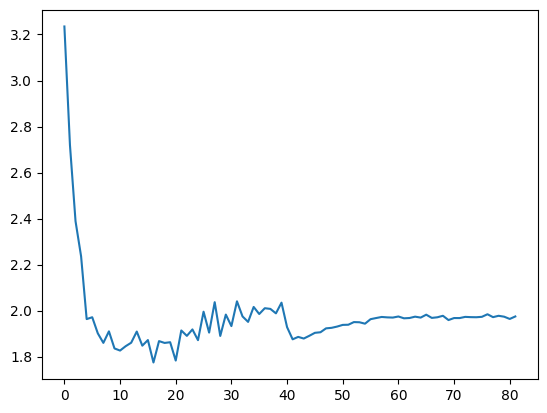

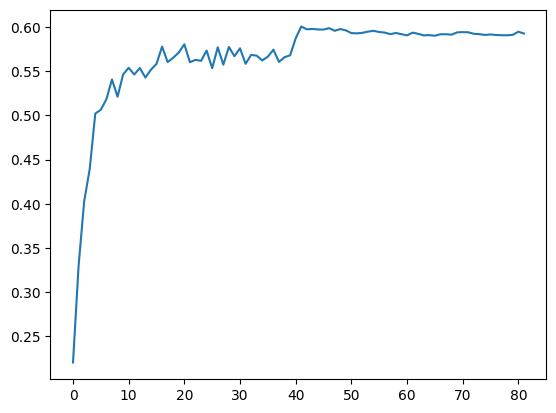

In [21]:
import matplotlib.pyplot as plt


#plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()    
#plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()        

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

w = tf.initializers.HeUniform()((3,3,16,32))
w = w.numpy()

# mudar para HE NORMAL
kaiming_normal = tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')
w1 = kaiming_normal((3,3,16,32))
w1 = w1.numpy()

plt.hist(np.ravel(w), bins=64)
plt.show()

plt.hist(np.ravel(w1), bins=64)
plt.show()
